**使用NIN模型进行图像分类**

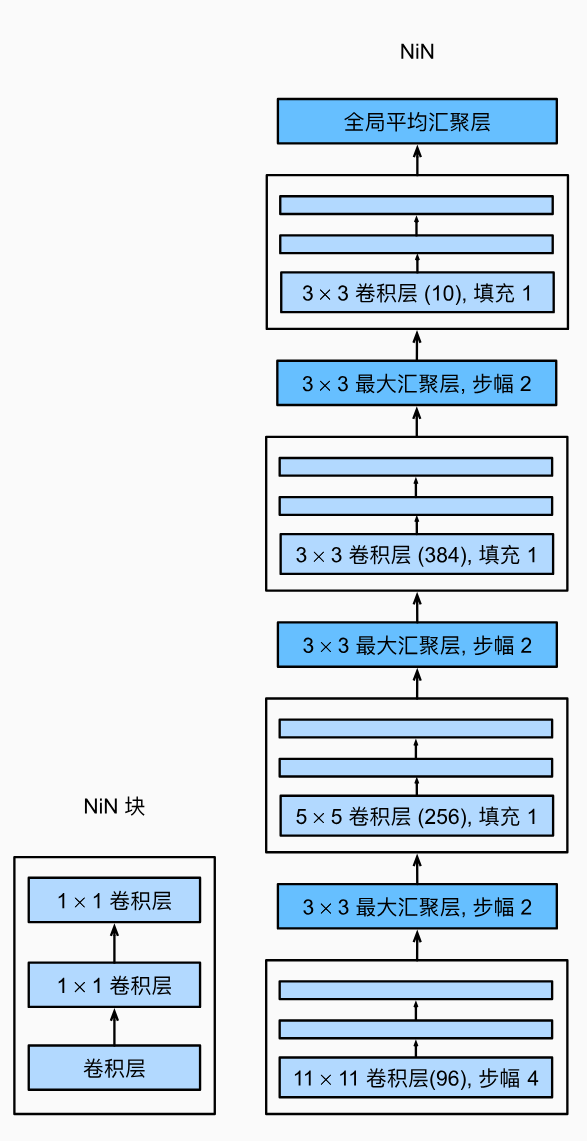

**一、数据预处理**

In [1]:
from frame_special import *
import numpy as np
import torchinfo

In [4]:
# 加载原始数据
train_arrays,train_labels = load_data()
test_arrays = load_test()

Load train data:   0%|          | 0/50000 [00:00<?, ?it/s]

Load test data: 100%|██████████| 300000/300000 [00:28<00:00, 10570.04it/s]


In [5]:
# 构造训练数据迭代器
batch_size = 64
train_dataset = TrainDataset(train_arrays,train_labels)
train_iter = data.DataLoader(train_dataset,batch_size,shuffle = True)

Load-Data-iter: 100%|██████████| 50000/50000 [00:04<00:00, 10229.58it/s]

load 50000 images!


In [6]:
# 构造测试数据迭代器
test_dataset = TestDataset(test_arrays)
test_iter = data.DataLoader(test_dataset,batch_size,shuffle = False)

Load-Data-iter: 100%|██████████| 300000/300000 [00:22<00:00, 13294.62it/s]

load 300000 images!


**二、NIN网络搭建**

In [7]:
def nin_block(in_channels,out_channels,kernel_size,strides,padding):
    """单个NIN块的生成"""
    blk = []
    blk.append(nn.Conv2d(in_channels,out_channels,kernel_size,strides,padding))
    blk.append(nn.ReLU())
    blk.append(nn.Conv2d(out_channels,out_channels,kernel_size = 1))
    blk.append(nn.ReLU())
    blk.append(nn.Conv2d(out_channels,out_channels,kernel_size = 1))
    blk.append(nn.ReLU())
    return nn.Sequential(*blk)

In [8]:
def nin(in_channels,class_nums):
    """NIN网络架构"""
    net = nn.Sequential(
    nin_block(in_channels, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    nin_block(384, class_nums, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)), # 全局池化，将四维的输出转成二维的输出，其形状为(批量大小,10)
    nn.Flatten())
    return net


In [19]:
# 测试网络架构
input = torch.rand((1,3,244,244))
net = nin(in_channels = 3,class_nums = 10)
# for p in net:
#     print(p)
print(torchinfo.summary(net,input.shape))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Sequential: 1-1                        [1, 96, 59, 59]           --
│    └─Conv2d: 2-1                       [1, 96, 59, 59]           34,944
│    └─ReLU: 2-2                         [1, 96, 59, 59]           --
│    └─Conv2d: 2-3                       [1, 96, 59, 59]           9,312
│    └─ReLU: 2-4                         [1, 96, 59, 59]           --
│    └─Conv2d: 2-5                       [1, 96, 59, 59]           9,312
│    └─ReLU: 2-6                         [1, 96, 59, 59]           --
├─MaxPool2d: 1-2                         [1, 96, 29, 29]           --
├─Sequential: 1-3                        [1, 256, 29, 29]          --
│    └─Conv2d: 2-7                       [1, 256, 29, 29]          614,656
│    └─ReLU: 2-8                         [1, 256, 29, 29]          --
│    └─Conv2d: 2-9                       [1, 256, 29, 29]          65,

**三、模型训练**

注：训练过程中要调整图像大小

In [20]:
# 定义超参数
num_epochs = 20
lr = 3e-5

# 损失函数
loss_fn = nn.CrossEntropyLoss()

In [21]:
import torch.nn.functional as F
def train_resize(net : nn.Sequential,train_iter,lr,num_epochs,loss_fn,resize_shape = (244,244)):
    """训练函数"""
    # devices_nums = torch.cuda.device_count()
    # devices = []
    # for i in range(devices_nums):
    #     devices.append(try_gpu(i = i))
    device = try_gpu(i = 0)
    net = net.to(device)
    net.train()
    optimzer = torch.optim.Adam(net.parameters(),lr = lr)
    loss_plt = []
    for epoch in range(num_epochs):
        loss_temp = 0
        total_nums = 0
        loop = tqdm(enumerate(train_iter),total = len(train_iter))
        for batch_idx,batch in loop:
            X,Y = batch
            X = X.to(device)
            X = F.interpolate(X, size=resize_shape, mode='bilinear')
            Y = Y.to(device)
            total_nums += X.shape[0]

            optimzer.zero_grad()
            y_pred = net(X)
            loss = loss_fn(y_pred,Y)
            loss.sum().backward()
            optimzer.step()

            loss_temp += loss.sum().item()
            loop.set_description(f'Epoch [{epoch + 1}/{num_epochs}]')
            loop.set_postfix({"LOSS" : loss_temp / total_nums})
        loss_plt.append(loss_temp / total_nums)
    return loss_plt


In [22]:
loss_plt = train_resize(net,train_iter,lr,num_epochs,loss_fn)

Epoch [20/20]: 100%|██████████| 782/782 [00:14<00:00, 53.04it/s, LOSS=0.0236]


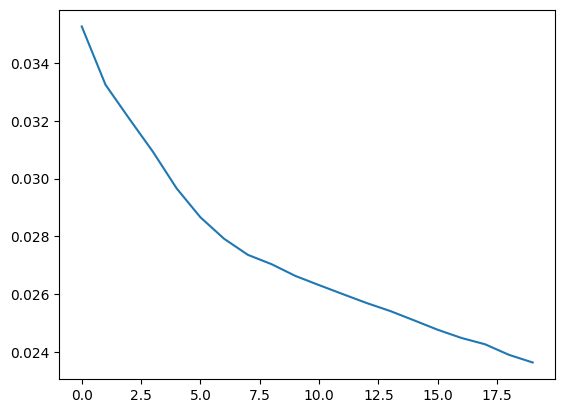

In [23]:
# 训练损失展示
import matplotlib.pyplot as plt
plt.plot(np.arange(len(loss_plt)),loss_plt)
plt.show()

In [24]:
# 保存模型
torch.save(net,"models/NIN-1.pt")
print(f"model save successfully!")

model save successfully!


**四、模型评估**

In [25]:
def count_accurancy_resize(net,train_iter,resize_shape = (244,244)):
    """训练集上准确率测试"""
    device = try_gpu(i = 0)
    net.eval()
    net.to(device)
    total_nums = 0
    ans = 0
    loop = tqdm(train_iter,total = len(train_iter),desc = "Eval")
    for X,Y in loop:
        total_nums += X.shape[0]
        X = X.to(device)
        X = F.interpolate(X, size=resize_shape, mode='bilinear')
        Y = Y.to(device).argmax(dim = 1)
        # print(X.shape,Y.shape)
        y_pred = net(X).argmax(dim = 1)
        # print(y_pred.shape)
        ans += (y_pred == Y).sum().item()
    return ans / total_nums

In [27]:
# 评估训练集
net = torch.load("models/NIN-1.pt",weights_only = False)
acc = count_accurancy_resize(net,train_iter)
print(acc)

Eval: 100%|██████████| 782/782 [00:04<00:00, 171.24it/s]

0.4535


In [ ]:
def predict_resize(net,test_iter,idx2obj,resize_shape = (244,244)):
    """测试集上预测推理"""
    device = try_gpu(i = 0)
    net.eval()
    net.to(device)
    loop = tqdm(test_iter,desc = "Predict")
    idx = 0
    with open ("result.txt","w",encoding = 'utf-8') as file:
        for X in loop:
            X = X.to(device)
            X = F.interpolate(X, size=resize_shape, mode='bilinear')
            pred = net(X).argmax(dim = 1)
            for k in pred:
                idx += 1
                file.write(str(idx) + "," + idx2obj[k.item()] + "\n")

In [ ]:
# 评估测试集
predict_resize(net,test_iter,train_dataset.idx2obj)